## Torch snippets is my go to library as it makes all the imports and plotting metrics very easy 

!pip install torch_snippets

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

# Only by importing torch_snippets required things would be imported
# Above packages are imported for reference only, code would work just fine without the above imports too
from torch_snippets import *
import wandb
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
device

'cuda'

In [27]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, folder, transform=None, \
                 should_invert=True):
        self.folder = folder
        self.items = Glob(f'{self.folder}/*/*')
        self.transform = transform
    def __len__(self):        
        return len(self.items)
    def __getitem__(self, ix):
        itemA = self.items[ix]
        #person = fname(parent(itemA))
        person = str(itemA).rsplit('\\',2)[1]
        same_person = randint(2)
        if same_person:
            itemB = choose(Glob(f'{self.folder}/{person}/*', \
                                silent=True))
        else:
            while True:
                itemB = choose(self.items)
                #if person != fname(parent(itemB)):
                if person != str(itemB).rsplit('\\',2)[1]:
                    break
        imgA = read(itemA)
        imgB = read(itemB)
        if self.transform:
            imgA = self.transform(imgA)
            imgB = self.transform(imgB)
            return imgA, imgB, np.array([1-same_person])

In [28]:
trn_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(5, (0.01,0.2), \
                            scale=(0.9,1.1)),
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5),(0.5))
])

val_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5),
                         (0.5),(0.5))
])

In [37]:
str(Glob('./data/faces/training/*/*')[1]).rsplit('\\',2)[1]

'anne_hathaway'

In [29]:
trn_ds=SiameseNetworkDataset(folder="./data/faces/training/", transform=trn_tfms)
val_ds=SiameseNetworkDataset(folder="./data/faces/testing/",transform=val_tfms)

In [30]:
trn_dl = DataLoader(trn_ds, shuffle=True, batch_size=8)
val_dl = DataLoader(val_ds, shuffle=False, batch_size=8)

In [19]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1, \
                  padding_mode='reflect'),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
    )

In [20]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.features = nn.Sequential(
            convBlock(1,4),
            convBlock(4,8),
            convBlock(8,8),
            nn.Flatten(),
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 500), nn.ReLU(inplace=True),
            nn.Linear(500, 5) 
        ) 
    def forward(self, input1, input2):
        output1 = self.features(input1)
        output2 = self.features(input2)
        return output1, output2

In [21]:
class ContrastiveLoss(torch.nn.Module):
    """    Contrastive loss function.Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf    """
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, \
                                                 output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * \
                                      torch.pow(euclidean_distance, 2) + \
                                      (label) * torch.pow(torch.clamp( \
                                                                      self.margin - euclidean_distance, \
                                                                      min=0.0), 2))
        acc = ((euclidean_distance>0.6)==label).float().mean()
        return loss_contrastive, acc

In [22]:
def train_batch(model, data, optimizer, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    optimizer.zero_grad()
    codesA, codesB = model(imgsA, imgsB)
    loss, acc = criterion(codesA, codesB, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    codesA, codesB = model(imgsA, imgsB)
    loss, acc = criterion(codesA, codesB, labels)
    return loss.item(), acc.item()

In [31]:
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.00)

In [32]:
def train(n_epochs=200):
    log = Report(n_epochs)
    for epoch in range(n_epochs):
        N = len(trn_dl)
        for i, data in enumerate(trn_dl):
            loss, acc = train_batch(model, data, optimizer, \
                                    criterion)
            log.record(epoch+(1+i)/N,trn_loss=loss,trn_acc=acc, \
                       end='\r')
            N = len(val_dl)
            for i, data in enumerate(val_dl):
                loss, acc = validate_batch(model, data, \
                                           criterion)
                log.record(epoch+(1+i)/N,val_loss=loss,val_acc=acc, \
                           end='\r')
                if (epoch+1)%20==0: log.report_avgs(epoch+1)
    return log

In [25]:
wandb.init()

wandb: Currently logged in as: sheikh-sahil12299. Use `wandb login --relogin` to force relogin


In [33]:
log = train(200)

TypeError: pic should be Tensor or ndarray. Got <class 'NoneType'>.

100%|██████████████████████████████████████████████████████████████████████████████| 301/301 [00:00<00:00, 1291.85it/s]


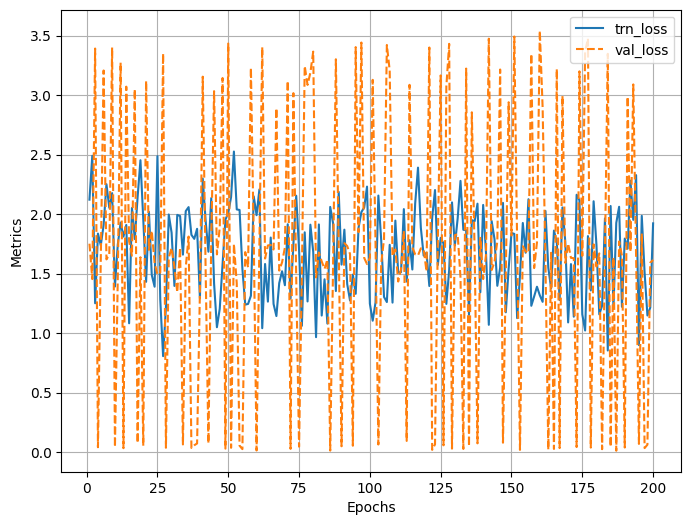

100%|██████████████████████████████████████████████████████████████████████████████| 301/301 [00:00<00:00, 1454.10it/s]


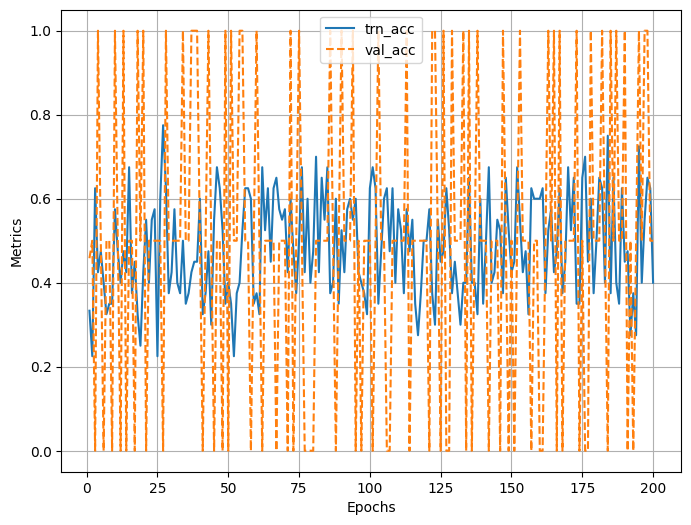

In [48]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

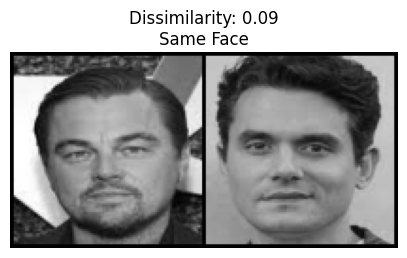

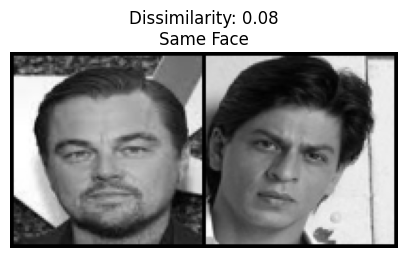

In [49]:
model.eval()
val_dl = DataLoader(val_ds,batch_size=1, \
                    shuffle=True)
dataiter = iter(val_dl)
x0, _, _ = next(dataiter)
for i in range(2):
    _, x1, label2 = next(dataiter)
    concatenated = torch.cat((x0*0.5+0.5, x1*0.5+0.5),0)
    output1,output2 = model(x0.cuda(),x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    output = 'Same Face' if euclidean_distance.item() < 0.6 \
    else 'Different'
    show(torchvision.utils.make_grid(concatenated), \
         title='Dissimilarity: {:.2f}\n{}'. \
         format(euclidean_distance.item(), output))
    plt.show()

# Plot Feature Maps

In [1]:
def visualise_feature_maps():
    model_weights =[]
    conv_layers = []
    # get all the model children as list
    model_children = list(model.children())
    #counter to keep count of the conv layers
    counter = 0
    #append all the conv layers and their respective wights to the list
    for i in range(len(model_children)):
        if type(model_children[i]) == nn.Conv2d:
            counter+=1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
        elif type(model_children[i]) == nn.Sequential:
            for j in range(len(model_children[i])):
                for child in model_children[i][j].children():
                    if type(child) == nn.Conv2d:
                        counter+=1
                        model_weights.append(child.weight)
                        conv_layers.append(child)
    
    """
    # pass the image through the layer and get the list of outputs
    """
    outputs = []
    names = []
    for layer in conv_layers[0:]:
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))
    print(len(outputs))
    #print feature_maps
    for feature_map in outputs:
        print(feature_map.shape)
    
    """
    Generate feature map from the outputs
    """
    processed = []
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale / feature_map.shape[0]
        processed.append(gray_scale.data.cpu().numpy())
    
    """
    Plot the featuremaps
    """
    fig = plt.figure(figsize=(30, 50))
    for i in range(len(processed)):
        a = fig.add_subplot(5, 4, i+1)
        imgplot = plt.imshow(processed[i])
        a.axis("off")
        a.set_title(names[i].split('(')[0], fontsize=30)
    plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')